# Preprocessing and save datasets as tfrecords

In [2]:
# Dependencies

 # TensorFlow and tf.keras
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)
from tensorflow import keras

# Helper libraries
import os
import os.path
import glob
import librosa
import librosa.display
from librosa.display import waveshow
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as pd
import pprint
import random
import time

# Check if the GPU is available
print("GPU", "available, YES" if tf.config.list_physical_devices("GPU") else "no GPU")



Tensorflow Version: 2.13.0
GPU available, YES


In [11]:
# load global settings in config-dictionary
with open('./MA_CONFIG.json', 'r') as fp:
  config = json.load(fp)


# set sr
config['sr'] = 16000


# print config
print(json.dumps(config, indent=4))

# save config to disk
with open('./MA_CONFIG.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)


{
    "activation_func": "tanh",
    "batch_size": 16,
    "dropout_rate": 0.5,
    "filter_size": 64,
    "fps_noisy": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/noisySpeech",
    "fps_produced": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/producedSpeech",
    "fps_voicefixer": "/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/voicefixerOutput",
    "hop_length": 64,
    "input_shape": [
        132300,
        1
    ],
    "kernel_size": 5,
    "learning_rate": 0.002,
    "n_epochs": 20,
    "n_fft": 512,
    "n_mels": 16,
    "offset": 6,
    "sample_length": 20,
    "shuffle_buffer_size": 300,
    "sr": 16000,
    "test_dataset_path": "../Dataset/test.tfrecord",
    "train_dataset_path": "../Dataset/train.tfrecord",
    "win_length": 512
}


# func to save dataset to tfrecords of ~100mb

In [13]:
def load_and_process_data(file_path):

    # paths for ground truths prod files
    fps_prod = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Data/allFiles/producedSpeech/*.wav')
    
    # load audio data 
    y, _ = librosa.load(file_path, sr=config['sr'], mono=True, offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_fast')

    # get string with speaker and scriptname
    label = file_path.split('/')[-1]
    label = label[:10]
    for filename in fps_prod:
        if label in filename:
            fp = filename
            break

    # load corresponding produced audio file
    y_truth, _ = librosa.load(fp, sr=config['sr'], mono=True, offset=0.0, duration=None, 
                             dtype=np.float32, res_type='kaiser_fast')
    
    # align audio signals
    shift_s = 251/22050 # 251 samples bei sr22050 = 15ms
    shift = int(shift_s * config['sr'])
    y = np.concatenate((np.zeros(shift), y))
    y = y[:-shift]

    # cut audio into 3s frames
    seg = 3*int(config['sr'])
    y_3s = librosa.util.frame(y, frame_length=seg, hop_length=seg).T
    y_truth_3s = librosa.util.frame(y_truth, frame_length=seg, hop_length=seg).T    

    # get shape
    print('y_3s.shape:', y_3s.shape)
    print('y_truth_3s.shape:', y_truth_3s.shape)

    return y_3s, y_truth_3s


def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# tfrecords writer
def save_tfrecords(tfrecords_path: str,
                   voicefixer_list: list,
                   produced_list: list,
                   config: dict):

    # tfrecords writer
    with tf.io.TFRecordWriter(tfrecords_path) as writer:
        for v_array, p_array in zip(voicefixer_list, produced_list):

            # encode
            v_encoded = tf.audio.encode_wav(v_array[:, np.newaxis], config['sr'])
            p_encoded = tf.audio.encode_wav(p_array[:, np.newaxis], config['sr'])
        
            # save feature
            feature = {'voicefixer': _bytes_feature(v_encoded),
                       'produced': _bytes_feature(p_encoded)}
            features = tf.train.Features(feature=feature)
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())


        # close writer
        writer.close()

# Save Train Dataset

In [15]:
# folder with the training data
train_files = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train/*.wav')
train_files = train_files[:15]
#train_files = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train/f1_script1_ipad_balcony1_voicefixer.wav')

voicefixer_list = []
produced_list = []

# for 10s files
#length_tf_records = 60
# for 3s files
length_tf_records = 180
sr = config['sr']


i=0
for idx, file in enumerate(train_files):
    voicefixer, produced = load_and_process_data(file)
    voicefixer_list.extend(voicefixer)
    produced_list.extend(produced)
    print(len(voicefixer_list), len(produced_list))

    if len(voicefixer_list) > (length_tf_records):
        save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/train_3s_{sr}Hz_{i}.tfrecords', voicefixer_list[:length_tf_records], produced_list[:length_tf_records], config)
        voicefixer_list = voicefixer_list[length_tf_records:]
        produced_list = produced_list[length_tf_records:]
        i=i+1
        print(f'tfrecord #{i} saved')



y_3s.shape: (48, 48000)
y_truth_3s.shape: (48, 48000)
48 48
y_3s.shape: (64, 48000)
y_truth_3s.shape: (64, 48000)
112 112
y_3s.shape: (52, 48000)
y_truth_3s.shape: (52, 48000)
164 164
y_3s.shape: (51, 48000)
y_truth_3s.shape: (51, 48000)
215 215
tfrecord #1 saved
y_3s.shape: (49, 48000)
y_truth_3s.shape: (49, 48000)
84 84
y_3s.shape: (63, 48000)
y_truth_3s.shape: (63, 48000)
147 147
y_3s.shape: (54, 48000)
y_truth_3s.shape: (54, 48000)
201 201
tfrecord #2 saved
y_3s.shape: (66, 48000)
y_truth_3s.shape: (66, 48000)
87 87
y_3s.shape: (53, 48000)
y_truth_3s.shape: (53, 48000)
140 140
y_3s.shape: (62, 48000)
y_truth_3s.shape: (62, 48000)
202 202
tfrecord #3 saved
y_3s.shape: (40, 48000)
y_truth_3s.shape: (40, 48000)
62 62
y_3s.shape: (57, 48000)
y_truth_3s.shape: (57, 48000)
119 119
y_3s.shape: (62, 48000)
y_truth_3s.shape: (62, 48000)
181 181
tfrecord #4 saved
y_3s.shape: (62, 48000)
y_truth_3s.shape: (62, 48000)
63 63
y_3s.shape: (53, 48000)
y_truth_3s.shape: (53, 48000)
116 116


# Save test Dataset

In [ ]:
# folder with the training data
test_files = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/test/*.wav')
test_files = test_files

voicefixer_list = []
produced_list = []
# for 10s files
#length_tf_records = 60
# for 3s files
length_tf_records = 180

i=0
for idx, file in enumerate(test_files):
    voicefixer, produced = load_and_process_data(file)
    voicefixer_list.extend(voicefixer)
    produced_list.extend(produced)
    print(len(voicefixer_list), len(produced_list))

    if len(voicefixer_list) > (length_tf_records):
        save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/test_tfrecords/test_3s_{i}.tfrecords', voicefixer_list[:length_tf_records], produced_list[:length_tf_records], config)
        voicefixer_list = voicefixer_list[length_tf_records:]
        produced_list = produced_list[length_tf_records:]
        i=i+1
        print(f'tfrecord #{i} saved')



# Save valid Dataset

In [ ]:
# folder with the training data
valid_files = glob.glob('/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/valid/*.wav')
valid_files = valid_files

voicefixer_list = []
produced_list = []
# for 10s files
#length_tf_records = 60
# for 3s files
length_tf_records = 180

i=0
for idx, file in enumerate(valid_files):
    voicefixer, produced = load_and_process_data(file)
    voicefixer_list.extend(voicefixer)
    produced_list.extend(produced)
    print(len(voicefixer_list), len(produced_list))

    if len(voicefixer_list) > (length_tf_records):
        save_tfrecords(f'/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/valid_tfrecords/valid_3s_{i}.tfrecords', voicefixer_list[:length_tf_records], produced_list[:length_tf_records], config)
        voicefixer_list = voicefixer_list[length_tf_records:]
        produced_list = produced_list[length_tf_records:]
        i=i+1
        print(f'tfrecord #{i} saved')
    
    


# Check the Data by plot and audio display

(48000, 1) (48000, 1)
float32 float32


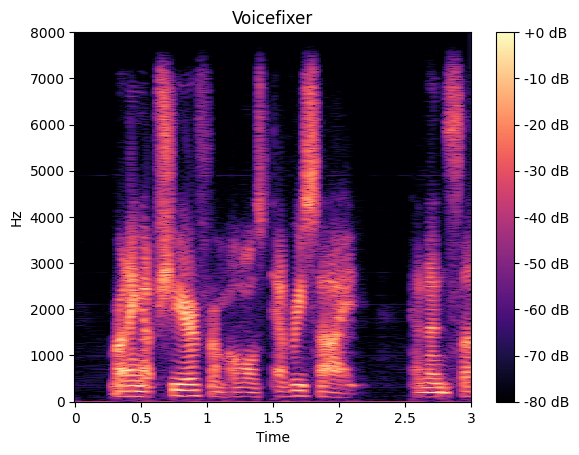

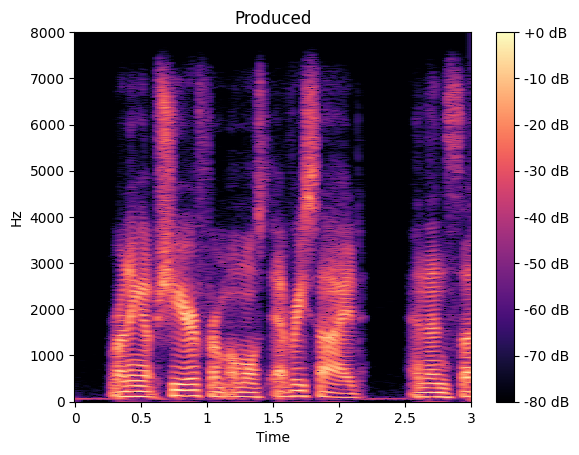

In [17]:
import os
from scipy.io.wavfile import write
from helpers import float2pcm
from helpers import decode_tf_records

AUTOTUNE = tf.data.experimental.AUTOTUNE

# load tf records
path = '/Users/marius/Documents/Uni/TU_Berlin_Master/Masterarbeit/Dataset/train_tfrecords/'
dataset = tf.data.TFRecordDataset(os.path.join(path, 'train_3s_16000Hz_1.tfrecords'))
dataset = dataset.map(decode_tf_records, num_parallel_calls=AUTOTUNE)


dataset = dataset.as_numpy_iterator()
for i, sample in enumerate(dataset):

    wav_VF = sample[0]
    wav_P = sample[1]

    # get shape
    print(wav_VF.shape, wav_P.shape)
    # get dtype
    print(wav_VF.dtype, wav_P.dtype)


    V = np.abs(librosa.stft(np.transpose(wav_VF), n_fft=2048, hop_length=256, win_length=2048))
    P = np.abs(librosa.stft(np.transpose(wav_P), n_fft=2048, hop_length=256, win_length=2048))

    # convert to db
    voicefixer = librosa.amplitude_to_db(np.abs(V), ref=np.max)
    produced = librosa.amplitude_to_db(np.abs(P), ref=np.max)


    # plot
    librosa.display.specshow(np.squeeze(voicefixer), sr=config['sr'], hop_length=256, y_axis='linear', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Voicefixer')
    plt.show()

    librosa.display.specshow(np.squeeze(produced), sr=config['sr'], hop_length=256, y_axis='linear', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Produced')
    plt.show()

    
    write('./3_voicefixer.wav', int(config['sr']), float2pcm(wav_VF))
    write('./3_produced.wav', int(config['sr']), float2pcm(wav_P))

    break

In [ ]:
# # look at some example data from train dataset
# wavs = train_dataset.as_numpy_iterator()
# noisy = []
# gt = []

# # Setup Subplot
# nrows, ncols = 2, 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 9))


# # iterate over dataset
# for i, sample in enumerate(wavs):
    
#     # get the column and row by modulo and remainder
#     j = i % ncols
#     k = int(i / ncols)
    
#     # extract noisy and produced speech file from tensors
#     wave = sample[0]
#     ground_truth = sample[1]
        
#     # plot files
#     librosa.display.waveshow(np.squeeze(wave), x_axis='time', sr=config['sr'], ax=ax[k][j], label='test_file')
#     librosa.display.waveshow(np.squeeze(ground_truth), alpha=0.3, x_axis='time', sr=config['sr'], ax=ax[k][j], label='ground_truth')
#     ax[k][j].legend()
#     ax[k][j].axis('on')
#     ax[k][j].set_title('10s speech')  

#     # save speech to arrays
#     noisy.append(np.squeeze(wave))
#     gt.append(np.squeeze(ground_truth))
    
#     if i+1 == ncols*nrows:
#         break
    
# # adjust whitespace in between subplots        
# plt.subplots_adjust(hspace=0.25, wspace=0.15)
# plt.show()


# # listen to the audio samples
# for i in range(len(gt)):
#     print(f'----------- {i+1}. speechsnippet ---------------')
#     print('')
#     print(f'Voicefixer file')
#     pd.display(pd.Audio(noisy[i].T, rate=config['sr']))
#     print(f'corresponding produced file')
#     pd.display(pd.Audio(gt[i].T, rate=config['sr']))
#     print('')
